# Introduction
The police of New York City have a publicy published dataset describing shooting incidents beginning in 2006 and updated every calendar year. In this data set one can find information on the victim, perpatrator when available, time, place, and a few other pieces of information.

One piece of information in this data set is the STATISTICAL_MURDER_FLAG. This boolean variable describes if the shooting resulted in a fatality. This analysis will be concerned with if a model can accurately assert if a given event will be fatal based on the other parameters. Such a model would be a place to start to discover factors about incidents that could be controlled and possibly advise the public on ways to reduce the number of deaths caused by shootings in New York.

[For anyone curious about this data set, it can be found here](https://catalog.data.gov/dataset/nypd-shooting-incident-data-historic)

[The GitHub repository containing this notebook, a copy of the data set used, and footnotes describing the columns can be found here](https://github.com/maniclucky/DTSA5509_Final)

# Imports
This analysis uses a variety of scikit-learn modules. In addition, pandas is included for the data handling, matplotlib for plotting, and the warning module to suppress non-convergence warnings for the logistic regression model.

In [39]:
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV
import matplotlib.pylab as plt

# Ingestion
The data is downloaded directly from the City of New York's website and stored as a pandas dataframe.

In [40]:
rawData = pd.read_csv("https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv?accessType=DOWNLOAD")

# Data Exploration
The first thing to check is what the data looks like. A listing of data types and a sample row to gain an intuition about the data.

Many of the data column names are fairly intuitive. For the ones that are not, NYC provides a footnotes document for reference. This document is available in the GitHub repository.

A couple of not immediately intuitive fields:
* JURISDICTION_CODE: Describes the jurisdiction in which an event fall. This is different than the location variables. In this data set, the jurisdiciton codes mean patrol (0), transit (1), and housing (2). These would indicate if the event occurred on the street, in home, or on a highway.
* X/Y_COORD_CD: These values refer to the midblock x/y coordinates of the New York State Plane Coordinate System, Long Island Zone. Functionally, they serve as a location variable.

In [41]:
rawData.dtypes

INCIDENT_KEY                 int64
OCCUR_DATE                  object
OCCUR_TIME                  object
BORO                        object
LOC_OF_OCCUR_DESC           object
PRECINCT                     int64
JURISDICTION_CODE          float64
LOC_CLASSFCTN_DESC          object
LOCATION_DESC               object
STATISTICAL_MURDER_FLAG       bool
PERP_AGE_GROUP              object
PERP_SEX                    object
PERP_RACE                   object
VIC_AGE_GROUP               object
VIC_SEX                     object
VIC_RACE                    object
X_COORD_CD                 float64
Y_COORD_CD                 float64
Latitude                   float64
Longitude                  float64
Lon_Lat                     object
dtype: object

In [42]:
rawData.head(10)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,228798151,05/27/2021,21:30:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.058925e+06,180924.000000,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025)
1,137471050,06/27/2014,17:40:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1.005028e+06,234516.000000,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006)
2,147998800,11/21/2015,03:56:00,QUEENS,NaN,108,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,WHITE,1.007668e+06,209836.531250,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004)
3,146837977,10/09/2015,18:30:00,BRONX,NaN,44,0.0,NaN,NaN,False,...,NaN,NaN,<18,M,WHITE HISPANIC,1.006537e+06,244511.140625,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003)
4,58921844,02/19/2009,22:58:00,BRONX,NaN,47,0.0,NaN,NaN,True,...,M,BLACK,45-64,M,BLACK,1.024922e+06,262189.406250,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006)
5,219559682,10/21/2020,21:36:00,BROOKLYN,NaN,81,0.0,NaN,NaN,True,...,NaN,NaN,25-44,M,BLACK,1.004234e+06,186461.703125,40.678457,-73.927952,POINT (-73.92795224099996 40.678456718000064)
6,85295722,06/17/2012,22:47:00,QUEENS,NaN,114,0.0,NaN,NaN,False,...,NaN,NaN,25-44,M,BLACK,9.988600e+05,214885.000000,40.756482,-73.947266,POINT (-73.94726649399996 40.75648234300007)
7,71662474,03/08/2010,19:41:00,BROOKLYN,NaN,81,0.0,NaN,NaN,True,...,NaN,NaN,18-24,M,BLACK,1.002883e+06,192219.703125,40.694264,-73.932809,POINT (-73.93280863699994 40.694264056000065)
8,83002139,02/05/2012,05:45:00,QUEENS,NaN,105,0.0,NaN,NaN,False,...,NaN,NaN,25-44,M,BLACK,1.054366e+06,196628.406250,40.706107,-73.747107,POINT (-73.74710653899996 40.706106731000034)
9,86437261,08/26/2012,01:10:00,QUEENS,NaN,101,0.0,NaN,MULTI DWELL - APT BUILD,False,...,M,BLACK,25-44,M,BLACK,1.053937e+06,157130.421875,40.597697,-73.749065,POINT (-73.74906464199995 40.59769719800005)


In [43]:
rawData.iloc[0]

INCIDENT_KEY                                                   228798151
OCCUR_DATE                                                    05/27/2021
OCCUR_TIME                                                      21:30:00
BORO                                                              QUEENS
LOC_OF_OCCUR_DESC                                                    NaN
PRECINCT                                                             105
JURISDICTION_CODE                                                    0.0
LOC_CLASSFCTN_DESC                                                   NaN
LOCATION_DESC                                                        NaN
STATISTICAL_MURDER_FLAG                                            False
PERP_AGE_GROUP                                                       NaN
PERP_SEX                                                             NaN
PERP_RACE                                                            NaN
VIC_AGE_GROUP                                      

#### An important thing to be aware of in any data set is the sparsity of any given parameter. 
A column full of NaNs is not useful, and many modules do not tolerate NaN values.

In [44]:
rawData.isna().sum()

INCIDENT_KEY                   0
OCCUR_DATE                     0
OCCUR_TIME                     0
BORO                           0
LOC_OF_OCCUR_DESC          25596
PRECINCT                       0
JURISDICTION_CODE              2
LOC_CLASSFCTN_DESC         25596
LOCATION_DESC              14977
STATISTICAL_MURDER_FLAG        0
PERP_AGE_GROUP              9344
PERP_SEX                    9310
PERP_RACE                   9310
VIC_AGE_GROUP                  0
VIC_SEX                        0
VIC_RACE                       0
X_COORD_CD                     0
Y_COORD_CD                     0
Latitude                      10
Longitude                     10
Lon_Lat                       10
dtype: int64

### Finally a few plots to round out the exploration.

Casting the time of day from string to an integer is done prior to the full cleaning for the sake of plotting.

Included here are plots for:
* Scatter of the latitude/longitude
    * As one would expect, it is roughly shaped like New York City.
* Histogram of occurrence time of day, binned hourly
    * Also as one would expect, most shootings happen at night.

Text(0, 0.5, 'Latitude')

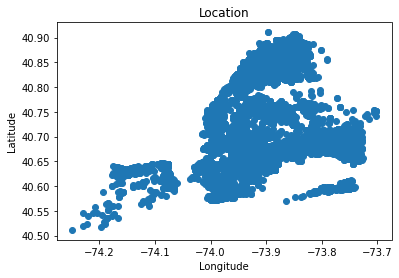

In [45]:
fig,ax = plt.subplots()
ax.scatter(rawData.Longitude, rawData.Latitude)
ax.set_title("Location")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

Text(0, 0.5, 'Number of Events')

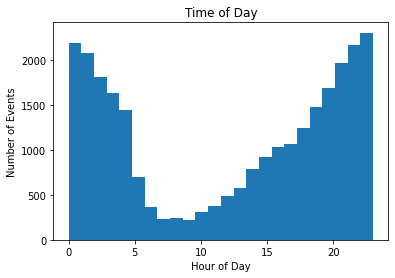

In [46]:
rawData['hour'] = pd.DatetimeIndex(rawData.OCCUR_TIME).hour
fix,ax = plt.subplots()
ax.hist(rawData['hour'],bins=24)
ax.set_title("Time of Day")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Number of Events")

# Cleaning
Before the data can be fed to a model, it needs to be cleaned

First, the temporal parameters need to be changed to something useful. A datetime would not be useful for predictions given that time only flows one direction. In lieu of that, a pair of new fields are created, month and hour. These are integer representations of when the event occurred, as a time of year and time of day.

These two are ordered categorical variables, which don't have to be cast as dummy variable necessarily. For this analysis, the preference was to capture the ordered nature of the data. Casting these as categorical is a completely valid approach and worth exploring in future iterations of this analysis. To account for the cyclicality, two more variables were created, month_rotate and hour_rotate. To create these, each was subtracted by half of the range (e.g. minus 6 for the year), and any value less than the minimum of the range was increased by the full original range (e.g. plus 12 for any value less than 1 for the year). Worth noting that this runs the risk of creating redundant variables.

From there the categorical variables of interest were cast into a series of dummy rows. For this analysis, these were the borough, victim description, and jurisdiction code parameters. Once the dummy variables were created, the parameters they were based on were dropped from the data set.

Finally, several parameters were dropped for various reasons:
* Lon_Lat, X/Y_COORD_CD are redundant with latitude/longitude
* Precinct is a categorical also similar to location and thus redundant
* Location description and perpatrator description parameters were sparse and removed for this stage of analysis
* Incident key is a unique metadata identifier and has no bearing on any of the real data
* Any rows with NaN values that remain, which should come out to 10 latitude/longitude values after previous drops.

In [47]:
print("Raw Data Rows/Columns before cleaning: %d, %d"%rawData.shape)
#Recast temporal parameters
rawData['month'] = pd.DatetimeIndex(rawData.OCCUR_DATE).month
rawData['month_rotate'] = rawData['month'] - 6
rawData.loc[rawData['month_rotate']<1,'month_rotate'] += 12
rawData['year'] = pd.DatetimeIndex(rawData.OCCUR_DATE).year
# rawData['hour'] = pd.DatetimeIndex(rawData.OCCUR_TIME).hour
rawData['hour_rotate'] = rawData['hour'] - 12
rawData.loc[rawData['hour_rotate']<0,'hour_rotate'] += 24
rawData.drop(columns=['OCCUR_DATE','OCCUR_TIME'],errors='ignore',inplace=True)

#Dummy out categoricals
rawData = pd.get_dummies(rawData,columns=['BORO','VIC_SEX','VIC_RACE','VIC_AGE_GROUP'])
rawData.drop(columns=['BORO','VIC_SEX','VIC_RACE','VIC_AGE_GROUP','JURISDICTION_CODE'],errors='ignore',inplace=True)

#Drop redundants
rawData.drop(columns=['Lon_Lat','X_COORD_CD','Y_COORD_CD','PRECINCT'],errors='ignore',inplace=True)
#Drop sparse items
rawData.drop(columns=['LOCATION_DESC','PERP_AGE_GROUP','PERP_SEX','PERP_RACE','LOC_CLASSFCTN_DESC','LOC_OF_OCCUR_DESC'],errors='ignore',inplace=True)
#Drop keys
rawData.drop(columns=['INCIDENT_KEY'],errors='ignore',inplace=True)
#Drop anything with NaNs
rawData.dropna(axis=0,inplace=True)
print("Raw Data Rows/Columns after cleaning: %d, %d"%rawData.shape)

Raw Data Rows/Columns before cleaning: 27312, 22
Raw Data Rows/Columns after cleaning: 27302, 30


In [48]:
rawData.iloc[0]

STATISTICAL_MURDER_FLAG                        False
Latitude                                   40.662965
Longitude                                 -73.730839
hour                                              21
month                                              5
month_rotate                                      11
year                                            2021
hour_rotate                                        9
BORO_BRONX                                     False
BORO_BROOKLYN                                  False
BORO_MANHATTAN                                 False
BORO_QUEENS                                     True
BORO_STATEN ISLAND                             False
VIC_SEX_F                                      False
VIC_SEX_M                                       True
VIC_SEX_U                                      False
VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE        False
VIC_RACE_ASIAN / PACIFIC ISLANDER              False
VIC_RACE_BLACK                                

# Modeling
For this analysis, several versions of three models are examined. A logistic classifier, a random forest, and an adaboost model. The goal is to determine which, if any, perform the task better than a random guess. Should such a model be discovered, further iterations of this analysis would become the next step.

The adaboost classifier varied the number of estimators and the learning rate.

The GridSearchCV object is used to automate exploring the hyperparameters. Threefold cross validation was used to reduce the time spent modeling. The object was set to verbose both to serve as a approximation of a progress bar as well as allowing one to see how things are going.

To have a metric to compare against, one needs to know what the accuracty of the model would be if it simply guessed. Regardless of error or any other metric, if a model cannot do even a small amount better than guessing, than it isn't worth looking at.

Below is the guess rate: the accuracy of the model if it simply asserted False for every prediciton without looking at any data. It comes out to 80.7%

In [49]:
guessRate = 1 - rawData.loc[rawData.STATISTICAL_MURDER_FLAG==True].sum()["STATISTICAL_MURDER_FLAG"]/rawData.shape[0]
print(guessRate)

0.8071203574829683


# Linear Model
The logistic classifier was set to emply both l1 and l2 regularization, denoted as 'elasticnet' in the model. The hyperparameters of interest were the l1 ratio, adjusts l1 and l2 regularization to linearly interpolate between them (e.g. 0 means only l1 regularization), and C to dictate the stringency of the regularization.

For this model, warnings were suppressed. With the number of iterations left at the default 100, few if any models managed converge before that point and the warning cluttered the output.

Running this cell takes less time than the other two to finish. The final output is that all the models ended up guessing and scoring 80.7% Looking at the coefficients for the best linear model (C=.1 and l1_ratio=0), it would appear that no particular parameter stood out as a predictor.

In [56]:
xData = rawData.loc[:,rawData.columns != 'STATISTICAL_MURDER_FLAG']
yData = rawData.STATISTICAL_MURDER_FLAG

linearParameters = {
    'l1_ratio':[0,.1,.5,.8,1],
    'C':[.1,1,10,100]
}
linearModel = LogisticRegression(solver='saga',penalty='elasticnet')
linearSearch = GridSearchCV(linearModel,linearParameters,verbose=3,cv=3)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    linearSearch.fit(xData,yData)

bestLinear = linearSearch.best_estimator_
print(linearSearch.best_score_)
print(linearSearch.best_params_)
print(bestLinear.coef_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END .................C=0.1, l1_ratio=0;, score=0.807 total time=   0.8s
[CV 2/3] END .................C=0.1, l1_ratio=0;, score=0.807 total time=   0.8s
[CV 3/3] END .................C=0.1, l1_ratio=0;, score=0.807 total time=   0.8s
[CV 1/3] END ...............C=0.1, l1_ratio=0.1;, score=0.807 total time=   1.0s
[CV 2/3] END ...............C=0.1, l1_ratio=0.1;, score=0.807 total time=   1.0s
[CV 3/3] END ...............C=0.1, l1_ratio=0.1;, score=0.807 total time=   1.1s
[CV 1/3] END ...............C=0.1, l1_ratio=0.5;, score=0.807 total time=   1.1s
[CV 2/3] END ...............C=0.1, l1_ratio=0.5;, score=0.807 total time=   1.0s
[CV 3/3] END ...............C=0.1, l1_ratio=0.5;, score=0.807 total time=   1.0s
[CV 1/3] END ...............C=0.1, l1_ratio=0.8;, score=0.807 total time=   1.1s
[CV 2/3] END ...............C=0.1, l1_ratio=0.8;, score=0.807 total time=   1.0s
[CV 3/3] END ...............C=0.1, l1_ratio=0.8;

# Random Forest Model
The random forest classifier held the number of predictors the same while adjusting maximum depth, min leaf samples, and ccp_alpha. All models used Gini index and the square root of the number of features as the maximum classifier.

Most models ended up hitting the guess rate of 80.7%, while a few did worse.

In [57]:
gridParameters = {
    # 'n_estimators' : [50,100,200],
    'max_depth':[None,1,5,10],
    'min_samples_leaf':[1,5,10],
    'ccp_alpha':[0,.001,.01,.1,1]
}
forestEstimator = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_features='sqrt',
    bootstrap=True
)

forestSearch = GridSearchCV(forestEstimator,gridParameters,verbose=3,cv=3)
forestSearch.fit(xData,yData)

bestForest = forestSearch.best_estimator_
print(forestSearch.best_score_)
print(forestSearch.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=1;, score=0.785 total time=   5.4s
[CV 2/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=1;, score=0.786 total time=   5.3s
[CV 3/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=1;, score=0.789 total time=   5.2s
[CV 1/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=5;, score=0.807 total time=   3.6s
[CV 2/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=5;, score=0.807 total time=   3.6s
[CV 3/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=5;, score=0.807 total time=   3.6s
[CV 1/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=10;, score=0.807 total time=   3.1s
[CV 2/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=10;, score=0.807 total time=   3.2s
[CV 3/3] END ccp_alpha=0, max_depth=None, min_samples_leaf=10;, score=0.807 total time=   3.1s
[CV 1/3] END ccp_alpha=0, max_depth=1, min_samples_leaf=1;, score=0.807 total time=   0.4

# AdaBoost Model
The number of estimators and the learning rate were the hyperparameters explored here. Otherwise, the default adaboost settings were left in place.

As with the random forest models, most models reached the guess rate. Notably several did significantly worse than guessing.

In [58]:
adaGrid = {
    'n_estimators' : [10,25,50,100],
    'learning_rate' : [.01,.1,1,10,100],
}
adaBoostModel = AdaBoostClassifier()

adaBoostSearch = GridSearchCV(adaBoostModel,adaGrid,verbose=3,cv=3)
adaBoostSearch.fit(xData,yData)

bestAda = forestSearch.best_estimator_
print(adaBoostSearch.best_score_)
print(adaBoostSearch.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END learning_rate=0.01, n_estimators=10;, score=0.807 total time=   0.2s
[CV 2/3] END learning_rate=0.01, n_estimators=10;, score=0.807 total time=   0.2s
[CV 3/3] END learning_rate=0.01, n_estimators=10;, score=0.807 total time=   0.2s
[CV 1/3] END learning_rate=0.01, n_estimators=25;, score=0.807 total time=   0.6s
[CV 2/3] END learning_rate=0.01, n_estimators=25;, score=0.807 total time=   0.6s
[CV 3/3] END learning_rate=0.01, n_estimators=25;, score=0.807 total time=   0.5s
[CV 1/3] END learning_rate=0.01, n_estimators=50;, score=0.807 total time=   1.2s
[CV 2/3] END learning_rate=0.01, n_estimators=50;, score=0.807 total time=   1.2s
[CV 3/3] END learning_rate=0.01, n_estimators=50;, score=0.807 total time=   1.2s
[CV 1/3] END learning_rate=0.01, n_estimators=100;, score=0.807 total time=   2.5s
[CV 2/3] END learning_rate=0.01, n_estimators=100;, score=0.807 total time=   2.5s
[CV 3/3] END learning_rate=0.01, n_

c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\

[CV 3/3] END learning_rate=100, n_estimators=10;, score=0.193 total time=   0.0s
[CV 1/3] END learning_rate=100, n_estimators=25;, score=0.193 total time=   0.0s
[CV 2/3] END learning_rate=100, n_estimators=25;, score=0.193 total time=   0.0s


c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\

[CV 3/3] END learning_rate=100, n_estimators=25;, score=0.193 total time=   0.0s
[CV 1/3] END learning_rate=100, n_estimators=50;, score=0.193 total time=   0.0s
[CV 2/3] END learning_rate=100, n_estimators=50;, score=0.193 total time=   0.0s


c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\

[CV 3/3] END learning_rate=100, n_estimators=50;, score=0.193 total time=   0.0s
[CV 1/3] END learning_rate=100, n_estimators=100;, score=0.193 total time=   0.0s
[CV 2/3] END learning_rate=100, n_estimators=100;, score=0.193 total time=   0.0s


c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_weight_boosting.py:637: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
c:\users\banks\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:1152: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  return fit_method(estimator, *args, **kwargs)


[CV 3/3] END learning_rate=100, n_estimators=100;, score=0.193 total time=   0.0s
0.8071203583070412
{'learning_rate': 0.01, 'n_estimators': 10}


# Conclusion
Before coming to conclusions, it is worth noting sources of bias in this analysis.

* Without making a political statement, the reputation of American police is well known. Any systemic biases are likely to work themselves into the data. This could manifest in over or under representing certain areas of the city that are deemed more or less dangerous for example.
* Perpatrator information may have information the model needed. This piece of information could be dangerous. If it does inform the model, it runs the risk of laymen assuming some feature of a class of people to be riskier than others, inducing racism, sexism, ageism, etc.
* The time parameters used may have been suboptimal. A categorial version may have worked better.

Unfortunately, no model with any set of parameters as defined above managed to do better than guessing. These models could have failed for a number of reasons. In no particular order:

* Insufficient data. Both in number of data points as well as the kind of data collected.
* A useful model may be a different one. A support vector machine may have been capable where these were not.
* The parameter ranges were too narrow. Additional parameters to tune, wider ranges, and more thoroughly explored ranges are all options to examing the existing models
* The odds of fatality are truly random and these factors have no impact on it at all.

Proposed options for the next step of the analysis in order of expected likelyhood of increased efficacy:
* Gather better data.
    * This is the avenue I would expect to yield the best results. Data on how many shots, location of injury if any, etc would likely better inform a model. Ultimately, this question is more of biology than crime and gathering more relevant data I would expect to yield better results.
* Attempt different models.
    * As stated above, SVC may be capable of achieving something that the models created cannot. Some combination of hyperparameters may generate useful results. Exploring alternates is a worthwhile endeavor.
* Gather more data.
    * Given that these are human lives as data, this is the most unpalatable option. Ideally, the existing data set would be capable of informing behavior in such a way that future data points would be reduced.
* Review the use case for such a model
    * This particular question may not have significant use, even if a model were to beat the guess rate. There may be better avenues to determine this answer than machine learning techniques.